In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
import math

In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent    
sys.path.append(str(project_root.resolve()))   # now Python can find modules there

import data_preparation   # regular import works

## Import data and transform

In [3]:
df_raw = pd.read_csv("../../Data/Refined/9019/asthma_prevalence_rate.csv")
df_raw

,Measure,Country Name,Disease,Metric,Year,Value,Country Code,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita),...,Oil consumption,u10,v10,d2m,t2m,sst,sp,skt,blh,PM2.5 pollution
0,Prevalence,Japan,Asthma,Rate,1990,5082.997034,JPN,..,100,9.4496485203842,...,1.97956,1.741828,1.021044,288.076401,292.252000,293.810320,102094.635435,293.628495,885.064589,13.37278
1,Prevalence,Japan,Asthma,Rate,1991,5092.603580,JPN,..,100,9.49356587396341,...,2.00120,2.286313,1.311337,288.337128,292.431930,293.870958,101983.583177,293.695755,892.493795,13.29348
2,Prevalence,Japan,Asthma,Rate,1992,5091.760356,JPN,..,100,9.49874382157927,...,2.04296,2.025161,1.717294,288.129279,292.314792,293.702229,102020.582682,293.530340,909.754829,13.22620
3,Prevalence,Japan,Asthma,Rate,1993,5081.664145,JPN,..,100,9.41083802642014,...,1.99111,1.625297,1.286398,287.874186,292.176917,293.652769,102097.751613,293.474290,902.488291,13.17147
4,Prevalence,Japan,Asthma,Rate,1994,5064.407124,JPN,..,100,9.80971896020067,...,2.10148,2.570448,1.109048,288.097394,292.441165,293.978702,102064.984418,293.796735,911.037764,13.12983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,Prevalence,Sudan,Asthma,Rate,2017,4825.147679,SDN,54.1,53,0.554132847201123,...,NaN,-6.390120,-2.174717,294.064998,298.129478,298.260798,101349.605304,299.081299,828.716632,59.81684
4946,Prevalence,Sudan,Asthma,Rate,2018,4814.203984,SDN,56.25,55.3,0.539979158318373,...,NaN,-6.720369,-1.962978,294.571177,298.391357,298.527902,101285.615172,299.362520,809.267977,58.69366
4947,Prevalence,Sudan,Asthma,Rate,2019,4803.510151,SDN,58.9,57.6,0.515394963684055,...,NaN,-6.393558,-1.910857,294.429075,298.369937,298.543588,101300.024220,299.369651,819.350147,51.93562
4948,Prevalence,Sudan,Asthma,Rate,2020,4800.033188,SDN,61,59.7,0.456248148211711,...,NaN,-7.191453,-2.245633,293.988485,297.929028,298.007299,101402.090968,298.836881,847.942231,45.83490


In [4]:
df_raw.columns

Index(['Measure', 'Country Name', 'Disease', 'Metric', 'Year', 'Value',
       'Country Code',
       'Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity (% of population)',
       'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Compulsory education, duration (years)', 'GDP (current US$)',
       'GDP per capita (constant 2015 US$)', 'Gini index',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'People using at least basic sanitation services (% of population)',
       'Population, total',
       'Poverty headcount ratio at national poverty lines (% of population)',
       'Renewable electricity output (% of total electricity output)',
       'Surface area (sq. km)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'CO2 emissions', 'Coal consumption', 'Energy use', 'Electricity use',
       'Raw materi

In [5]:
columns_to_keep = [col for col in df_raw.columns if col not in ['Country Name', 'Measure', 'Metric', 'Disease']]
df_excluded = df_raw[columns_to_keep]

In [6]:
df_prepared = data_preparation.preprocessing(df_excluded)

In [7]:
numeric_cols = ['Access to clean fuels and technologies for cooking (% of population)',\
                'Access to electricity (% of population)', 'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',\
                'Compulsory education, duration (years)', 'GDP (current US$)','GDP per capita (constant 2015 US$)', 'Gini index',\
                'Life expectancy at birth, total (years)','Mortality rate, infant (per 1,000 live births)',\
                'People using at least basic sanitation services (% of population)',\
                'Population, total','Poverty headcount ratio at national poverty lines (% of population)',\
                'Renewable electricity output (% of total electricity output)','Surface area (sq. km)',\
                'Unemployment, total (% of total labor force) (national estimate)','CO2 emissions', 'Coal consumption',\
                'Energy use', 'Electricity use','Raw materials extracted', 'Oil consumption', 'u10', 'v10', 'd2m',\
                't2m', 'sst', 'sp', 'skt', 'blh', 'PM2.5 pollution']

df_prepared[numeric_cols] = df_prepared[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_imputed = data_preparation.impute_nans_no_encoding(df_prepared)
df_imputed

C:\Users\rapso\miniconda3\envs\cours-apv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Year,Value,Country Code,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita),"Compulsory education, duration (years)",GDP (current US$),GDP per capita (constant 2015 US$),Gini index,...,Oil consumption,u10,v10,d2m,t2m,sst,sp,skt,blh,PM2.5 pollution
3192,1990,5036.145645,AFG,5.5,4.4,0.242594,6.0,3.521418e+09,308.318270,35.468205,...,0.363482,1.104314,-0.088217,276.621307,289.848591,58.150284,92054.426375,291.201735,654.260246,64.17410
3193,1991,5039.093665,AFG,5.5,4.4,0.232619,6.0,3.521418e+09,308.318270,35.603058,...,0.335764,1.089412,-0.166440,276.714434,289.569879,57.947076,92048.016117,290.929247,648.752654,64.18815
3194,1992,5039.644898,AFG,5.5,4.4,0.137051,6.0,3.521418e+09,308.318270,34.828000,...,0.280336,0.854820,-0.127481,278.314554,290.162019,58.259876,92013.210162,291.282056,616.513723,64.21053
3195,1993,4930.052845,AFG,5.5,4.4,0.119439,6.0,3.521418e+09,308.318270,33.396083,...,0.244022,1.096959,-0.054136,277.578857,290.150848,58.170655,92020.645875,291.251716,632.031749,64.24414
3196,1994,4797.861343,AFG,5.5,4.4,0.103700,6.0,3.521418e+09,308.318270,34.720037,...,0.210862,1.110697,-0.046804,276.891953,290.330769,58.064800,92055.177142,291.695890,660.147580,64.29192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4435,2017,2711.324736,ZWE,30.1,44.0,0.714627,7.0,5.107473e+10,1422.193460,44.300000,...,0.276841,-4.076857,0.314313,294.910941,298.817708,300.530401,101367.095519,300.315422,714.085136,17.99775
4436,2018,2717.755086,ZWE,30.3,45.4,0.816126,7.0,3.415606e+10,1471.394890,44.300000,...,0.312491,-3.782889,0.081234,294.823043,298.628095,300.351173,101341.051540,300.140890,677.411190,19.11210
4437,2019,2724.218125,ZWE,30.3,46.7,0.731382,7.0,2.571566e+10,1356.838211,50.300000,...,0.223145,-4.165231,0.365482,294.944064,298.681410,300.317168,101344.696514,300.119641,690.551983,18.52861
4438,2020,2731.155434,ZWE,30.5,52.7,0.584283,7.0,2.686856e+10,1230.191557,50.300000,...,0.292680,-4.280090,-0.113327,295.090925,298.796236,300.491428,101428.503891,300.278894,679.917596,19.49418


## Gradient Boosting Classifier

To measure the performances of the model, I am using accuracy and F1-score.

In [8]:
def country_kfold_splits(countries, k=5, random_state=None):
    """
    Generate train/test splits by countries for K-fold CV.
    Returns a list of tuples: (train_countries, test_countries)
    """
    countries = np.array(countries)
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(countries)
    
    folds = np.array_split(countries, k)  # split into k roughly equal folds
    
    splits = []
    for i in range(k):
        test_countries = folds[i]
        train_countries = np.hstack([folds[j] for j in range(k) if j != i])
        splits.append((train_countries, test_countries))
    return splits


In [17]:
def train_test_all_years_per_iteration(df, train_columns, target, excluded_columns, n_iterations, average='weighted', nb_classes = 3):
    countries = df['Country Code'].unique()
    
    # Store metrics for all years
    all_train_acc = {}
    all_train_f1 = {}
    all_train_balanced_acc = {}
    all_test_acc = {}
    all_test_balanced_acc = {}
    all_test_f1 = {}
    
    # feature score counter (across all iterations & all years)
    feature_scores = Counter()

    for i in range(n_iterations):
        print(f"Iteration {i} starts") 
        train_acc_list = []
        test_acc_list = []
        train_f1_list = []
        test_f1_list = []
        train_balanced_acc_list = []
        test_balanced_acc_list = []
        importances_per_year = []

        splits = country_kfold_splits(countries, k=5)

        for j, (train_countries, test_countries) in enumerate(splits):
            print(f"Sub-iteration {j}: Train {len(train_countries)} countries, Test {len(test_countries)} countries")
            
            df_train = df[df["Country Code"].isin(train_countries)]
            df_test = df[df["Country Code"].isin(test_countries)]
            
            # X_train, y_train, X_test, y_test
            features = [c for c in train_columns if c not in excluded_columns]
            X_train = df_train[features]
            y_train = df_train[target]
            X_test = df_test[features]
            y_test = df_test[target]
    
            # Compute sample weights based on class imbalance
            sample_weights = compute_sample_weight(
                class_weight="balanced",
                y=y_train
            )

            # Initialize Gradient Boosting Classifier            
            model = GradientBoostingClassifier()
            model.fit(X_train, y_train, sample_weight=sample_weights)
            
            y_train_pred = model.predict(X_train)
            train_acc_list.append(accuracy_score(y_train, y_train_pred))
            
            # Only compute F1 & balanced accuracy if both classes exist
            if len(np.unique(y_train)) == nb_classes:
                train_balanced_acc_list.append(balanced_accuracy_score(y_train, y_train_pred))                
                train_f1_list.append(f1_score(y_train, y_train_pred, average=average))  
            else:
                # Skip this fold for these metrics
                print("⚠️ One or more classes in y_train are not present for this fold — skipping F1 & balanced accuracy")
                
            y_pred = model.predict(X_test)
            test_acc_list.append(accuracy_score(y_test, y_pred))
            
            # Only compute F1 & balanced accuracy if both classes exist
            if len(np.unique(y_test)) == nb_classes:
                test_balanced_acc_list.append(balanced_accuracy_score(y_test, y_pred))
                test_f1_list.append(f1_score(y_test, y_pred, average=average))
            else:
                # Skip this fold for these metrics
                print("⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy")
                
            importance_dict = model.get_booster().get_score(importance_type='weight')  # or 'gain', 'cover'
            # Convert to pandas Series
            perm_importances = pd.Series(importance_dict).reindex(X_train.columns).fillna(0)
            
            # Take top 5 features of this fold
            top_5 = perm_importances.sort_values(ascending=False).head(5)
            feature_scores.update(top_5.index)
    
        # Store averaged metrics for this iteration
        all_train_acc[i] = np.mean(train_acc_list)
        all_test_acc[i] = np.mean(test_acc_list)
        all_train_f1[i] = np.mean(train_f1_list)
        all_test_f1[i] = np.mean(test_f1_list)
        all_train_balanced_acc[i] = np.mean(train_balanced_acc_list) 
        all_test_balanced_acc[i] = np.mean(test_balanced_acc_list)
            
        print(f"Iteration {i} done\n")   

    # ============================================================
    # PLOT: MSE & R2 per iteration
    # ============================================================
    
    # Prepare data
    mean_train_acc_values = list(all_train_acc.values())
    mean_test_acc_values = list(all_test_acc.values())
    mean_train_f1_values = list(all_train_f1.values())
    mean_test_f1_values = list(all_test_f1.values())
    mean_train_balanced_acc_values = list(all_train_balanced_acc.values())
    mean_test_balanced_acc_values = list(all_test_balanced_acc.values())
    sorted_iterations = range(n_iterations)
    
    # Create plots
    fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    
    # Accuracy plot
    axs[0].plot(sorted_iterations, mean_train_acc_values, marker='o', linestyle='--', color='orange', label='Train Accuracy')
    axs[0].plot(sorted_iterations, mean_test_acc_values, marker='o', linestyle='-', color='orange', label='Test Accuracy')
    axs[0].set_title('Mean Accuracy per Year')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # Balanced accuracy plot
    axs[1].plot(sorted_iterations, mean_train_balanced_acc_values, marker='o', linestyle='--', color='green', label='Train Balanced Accuracy')
    axs[1].plot(sorted_iterations, mean_test_balanced_acc_values, marker='o', linestyle='-', color='green', label='Test Balanced Accuracy')
    axs[1].set_title('Mean Balanced Accuracy per Year')
    axs[1].set_ylabel('Balanced Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    # F1 plot
    axs[2].plot(sorted_iterations, mean_train_f1_values, marker='s', linestyle='--', color='blue', label='Train F1')
    axs[2].plot(sorted_iterations, mean_test_f1_values, marker='s', linestyle='-', color='blue', label='Test F1')
    axs[2].set_title('Mean F1 Score per Year')
    axs[2].set_ylabel('F1 Score')
    axs[2].set_xlabel('Iteration')
    axs[2].legend()
    axs[2].grid(True)
    
    # Labels and legend
    plt.tight_layout()
    plt.show()

    global_mean_acc_test = np.mean(mean_test_acc_values)
    print(f"Mean Accuracy (test): {global_mean_acc_test}") 

    global_mean_balanced_acc_test = np.mean(mean_test_balanced_acc_values)
    print(f"Mean Balanced Accuracy (test): {global_mean_balanced_acc_test}") 
    
    global_mean_f1_test = np.mean(mean_test_f1_values)
    print(f"Mean F1 Score (test): {global_mean_f1_test}")   
    
    # ============================================================
    #  PLOT: Top 6 Most Important Features Across All Iterations
    # ============================================================

    top6 = feature_scores.most_common(6)
    feat_names = [f for f, s in top6]
    feat_scores = [s for f, s in top6]

    plt.figure(figsize=(10, 4))
    plt.barh(feat_names, feat_scores)
    plt.xlabel("Frequency Appearing in Top 5")
    plt.title("Top 6 Most Important Features (Across All Iterations)")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## 3 classes {0,1,2}

Initially, the target is a continuous numerical variable, meaning the task is naturally a regression problem (predicting a real-valued number).
To transform this into a classification problem, the continuous values are discretized into categories (classes) using pd.cut. This operation splits the range of the target into 3 equal-width intervals (bins) and assigns a class label to each interval:
- 0 -> Low range	
- 1 -> Medium range
- 2 -> High range

The continuous target is basically converted into three ordinal classes representing low, medium, and high values.

Iteration 0 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy
Sub-iteration 1: Train 131 countries, Test 33 countries
⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
Sub-iteration 3: Train 131 countries, Test 33 countries
⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy
Sub-iteration 4: Train 132 countries, Test 32 countr

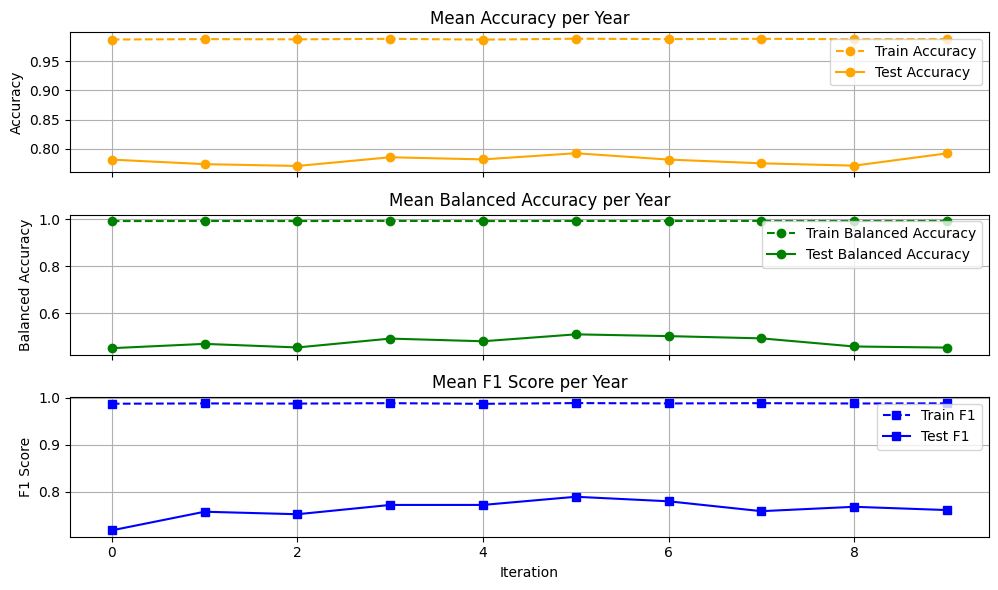

Mean Accuracy (test): 0.7807714960020757
Mean Balanced Accuracy (test): 0.4751721989048237
Mean F1 Score (test): 0.763207829015465


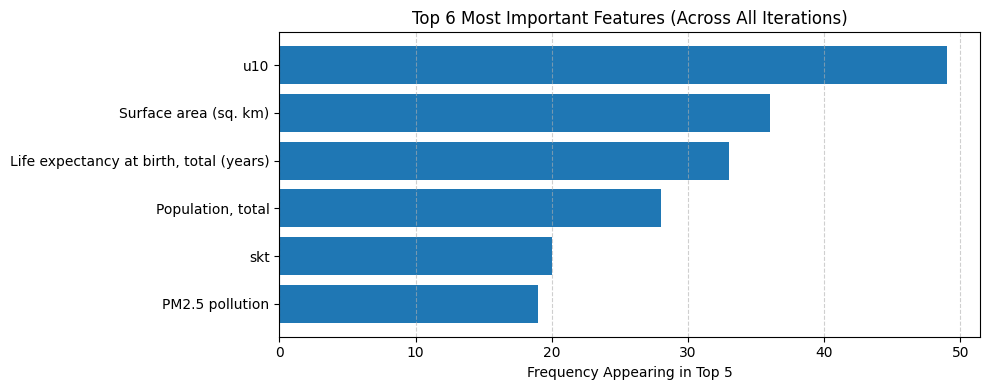

In [14]:
labels = [0, 1, 2]
df_imputed['y_class'] = pd.cut(df_imputed['Value'], bins=3, labels=labels)
train_test_all_years_per_iteration(df_imputed, df_imputed.columns, "y_class", ["y_class", "Value", "Country Code", "Year"], 10)

Iteration 0 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 131 countries, Test 33 countries
⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy
Sub-iteration 1: Train 131 countries, Test 33 countries
Sub-iteration 2: Train 131 countries, Test 33 countries
⚠️ One or more classes in y_test are not present for this fold — skipping F1 & balanced accuracy
Sub-iteration 3: Train 131 countries, Test 33 countries
Sub-iteration 4: Train 132 countries, Test 32 countries
Iteration 1 done

Iteration 2 starts
Sub-iteration 0: Train 131 countries, Test 33 countries


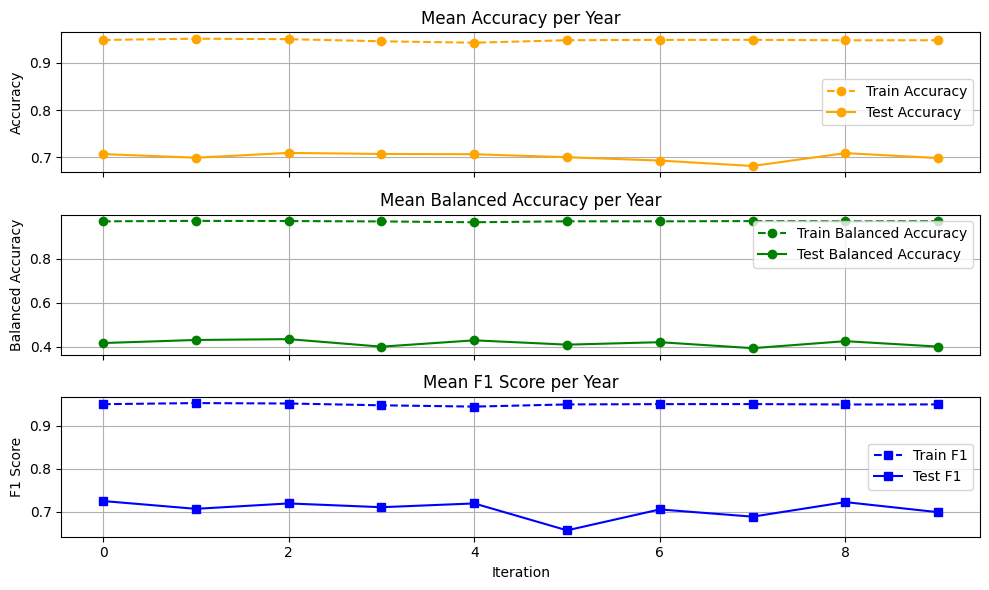

Mean Accuracy (test): 0.7012471879911617
Mean Balanced Accuracy (test): 0.4169699723687995
Mean F1 Score (test): 0.705793717415027


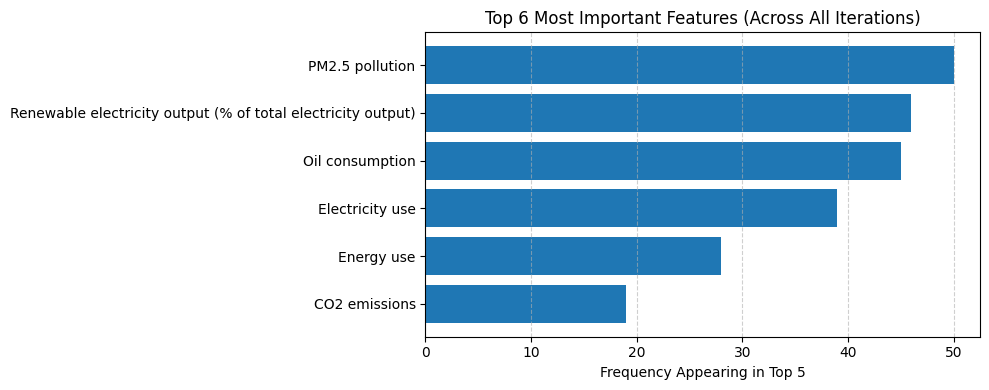

In [15]:
# training only on environmental factors

train_columns= ['Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
       'Renewable electricity output (% of total electricity output)',
       'CO2 emissions', 'Coal consumption', 'Energy use', 'Electricity use',
       'Raw materials extracted', 'Oil consumption', 'PM2.5 pollution']

train_test_all_years_per_iteration(df_imputed, train_columns, "y_class", ["y_class", "Country Code", "Year"], 10)

## Transformation into a binary problem

Here I turn this into a binary classification problem based on year-to-year change by comparing each value with the previous year for the same country.

Class counts:
y_increase
1    2487
0    2299
Name: count, dtype: int64

Class ratios:
y_increase
1    0.519641
0    0.480359
Name: proportion, dtype: float64
Iteration 0 starts
Sub-iteration 0: Train 129 countries, Test 33 countries
Sub-iteration 1: Train 129 countries, Test 33 countries
Sub-iteration 2: Train 130 countries, Test 32 countries
Sub-iteration 3: Train 130 countries, Test 32 countries
Sub-iteration 4: Train 130 countries, Test 32 countries
Iteration 0 done

Iteration 1 starts
Sub-iteration 0: Train 129 countries, Test 33 countries
Sub-iteration 1: Train 129 countries, Test 33 countries
Sub-iteration 2: Train 130 countries, Test 32 countries
Sub-iteration 3: Train 130 countries, Test 32 countries
Sub-iteration 4: Train 130 countries, Test 32 countries
Iteration 1 done

Iteration 2 starts
Sub-iteration 0: Train 129 countries, Test 33 countries
Sub-iteration 1: Train 129 countries, Test 33 countries
Sub-iteration 2: Train 130 countries, Test 32 countries
Sub-iteration 3: Trai

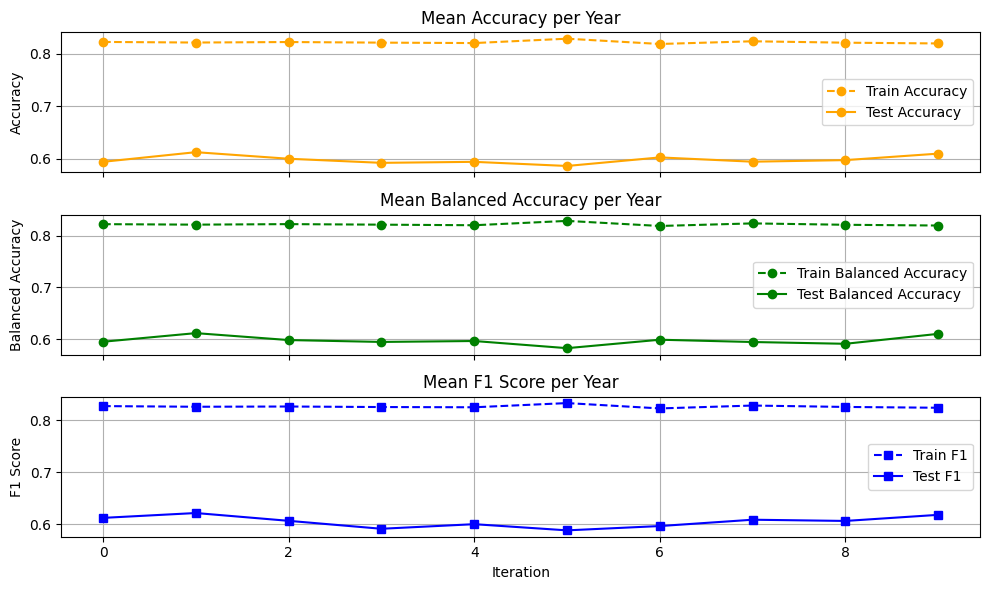

Mean Accuracy (test): 0.5979921965266481
Mean Balanced Accuracy (test): 0.5975170549279936
Mean F1 Score (test): 0.6047938728276641


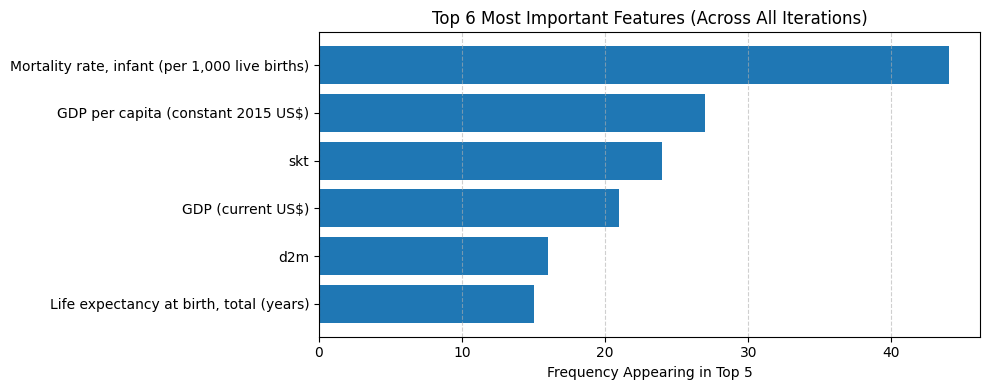

In [16]:
# Sort to ensure correct year-to-year comparison per country
df_imputed = df_imputed.sort_values(["Country Code", "Year"])

# Compute year-to-year change per country
df_imputed["Value_diff"] = (
    df_imputed
    .groupby("Country Code")["Value"]
    .diff()
)

# Create binary target:
# 1 = increase, 0 = decrease
df_imputed["y_increase"] = (df_imputed["Value_diff"] > 0).astype(int)

# Optional: remove rows where diff is NaN (first year per country)
df_first_year_excluded = df_imputed.dropna(subset=["Value_diff"])

# Check class distribution
class_counts = df_first_year_excluded["y_increase"].value_counts()
class_ratios = df_first_year_excluded["y_increase"].value_counts(normalize=True)

print("Class counts:")
print(class_counts)

print("\nClass ratios:")
print(class_ratios)

# Train with the new binary target
train_test_all_years_per_iteration(
    df_first_year_excluded,
    df_first_year_excluded.columns,
    "y_increase",
    ["y_increase", "Value", "Value_diff", "Country Code", "Year"],
    10, 
    'binary',
    2
)
